In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.stats import ttest_rel

In [27]:
def read_accuracy_from_file(file_path):
    accuracies = {}
    std_deviations = {}
    with open(file_path, 'r') as file:
        for line in file:
            if 'average accuracy' in line and 'Subject' in line:
                parts = line.split()
                subject = parts[1]  # The subject ID is now at index 1
                accuracy = float(parts[4])  # Accuracy is at index 4
                std_deviation = float(parts[-1])  # Standard deviation is at the last index
                accuracies[subject] = accuracy
                std_deviations[subject] = std_deviation
        # Calculate overall average accuracy
        overall_accuracy = np.mean(list(accuracies.values()))
        overall_std_deviation = np.mean(list(std_deviations.values()))
        accuracies['Average'] = overall_accuracy
        std_deviations['Average'] = overall_std_deviation
    return accuracies, std_deviations


def plot_accuracies_and_average(files, legends):

    matplotlib.rcParams['font.family'] = 'Times New Roman'
    all_accuracies = []
    all_std_devs = []
    subjects = set()

    for file_path in files:
        accuracies, std_devs = read_accuracy_from_file(file_path)
        all_accuracies.append(accuracies)
        all_std_devs.append(std_devs)
        subjects.update(accuracies.keys())
        
    plt.style.use('default')
    matplotlib.rcParams['font.family'] = 'Times New Roman'
    subjects.discard('Average')  # Remove 'Average' key for subject plot
    subjects = sorted(subjects, key=lambda x: int(x))
    # Setup the figure and gridspec
    fig = plt.figure(figsize=(10, 4), dpi=300)
    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 1], figure=fig)
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1], sharey=ax1)

    ax1_ticks = np.linspace(0.5, 1, 6)
    ax1.set_yticks(ax1_ticks)
    ax1.set_yticklabels([f"{int(tick*100)}" for tick in ax1_ticks])

    n_files = len(files)
    index = np.arange(len(subjects))
    bar_width = 0.8 / n_files - 0.05
    colors = ['#EDB120', '#0072BD'] 
    # Store accuracies for each subject by model to calculate std deviation later
    accuracies_by_model = [[] for _ in range(n_files)]

    for i, accuracies in enumerate(all_accuracies):
        for subject in subjects:
            acc = accuracies[subject] if subject in accuracies else np.nan
            accuracies_by_model[i].append(acc)
            
        ax1.bar(index + i * bar_width, [accuracies[subject] if subject in accuracies else 0 for subject in subjects],
                bar_width, color=colors[i], label=legends[i], yerr=[all_std_devs[i][subject] if subject in all_std_devs[i] else 0 for subject in subjects], capsize=3)

    ax1.set_xlabel('Subject ID')
    ax1.set_ylabel('Accuracy (%)')

    ax1.set_ylim(0.592, 1.03)
    ax1.set_xticks(index + bar_width / n_files * (n_files - 1) / 2)
    ax1.set_xticklabels(['S' + subject for subject in subjects])
    ax1.legend(loc='upper left', ncol=4)

    # Add a reference dotted line at 80% accuracy
    ax1.axhline(y=0.8, color='grey', linestyle='--', linewidth=1)

    # Calculate mean and std deviation for each model
    mean_accuracies = []
    std_devs = []
    for accuracies in accuracies_by_model:
        accuracies = np.array(accuracies)
        mean_accuracies.append(np.around(np.mean(accuracies), decimals=2))
        std_devs.append(np.nanstd(accuracies))

    # Number of models (or files)
    n_models = 2

    # Custom x positions - Generate positions to bring bars closer together
    bar_width = 0.2  # Width of each bar
    spacing = 0.1  # Space between bars
    x_positions = np.arange(n_models) * (bar_width + spacing)

    ax2.bar(x_positions, mean_accuracies, width=bar_width, color=colors, yerr=std_devs, capsize=5)

    top = max(mean_accuracies + std_devs) + 0.1
    line_y = [top, top]
    x1, x2 = x_positions
    ax2.plot([x1, x2], line_y, color="black", lw=1)

    # Draw vertical caps at the ends of the significance line
    ax2.plot([x1, x1], [top - 0.01, top ], color="black", lw=1.5)
    ax2.plot([x2, x2], [top - 0.01, top ], color="black", lw=1.5)

    # Add the significance marker (e.g., '*', '***', or 'n.s.' for not significant)
    # Example accuracies for two models (Replace with your actual accuracies_by_model data)
    model1_accuracies = np.array(accuracies_by_model[0])  # Accuracies of Model 1
    model2_accuracies = np.array(accuracies_by_model[1])  # Accuracies of Model 2
    
    # Perform t-test
    t_stat, p_value = ttest_rel(model2_accuracies, model1_accuracies, nan_policy='omit')  # 'omit' to ignore NaNs
    print(f"T-statistic: {t_stat}, P-value: {p_value}")

    # Draw significance lines and markers
    if p_value < 0.001:
        signif_mark = "***"
    else:
        signif_mark = "n.s."

    ax2.text((x1+x2)/2, top - 0.005, signif_mark, ha='center', va='bottom', fontsize=12)

    # Set x-axis limits to add padding at the edges
    # Calculate padding based on the number of models and the spacing
    padding = spacing * 2
    ax2.set_xlim(-padding, n_models * (bar_width + spacing) - spacing)

    # Optionally, update the x-tick positions and labels to align with the new bar positions
    ax2.set_xlabel('Average Accuracy')
    ax2.set_xticks([])
    
    for i, acc in enumerate(mean_accuracies):
        ax2.text(x_positions[i], acc + 0.01, f'{acc*100:.0f}%', ha='right', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()



T-statistic: 5.311203527588593, P-value: 3.9862433275768174e-05


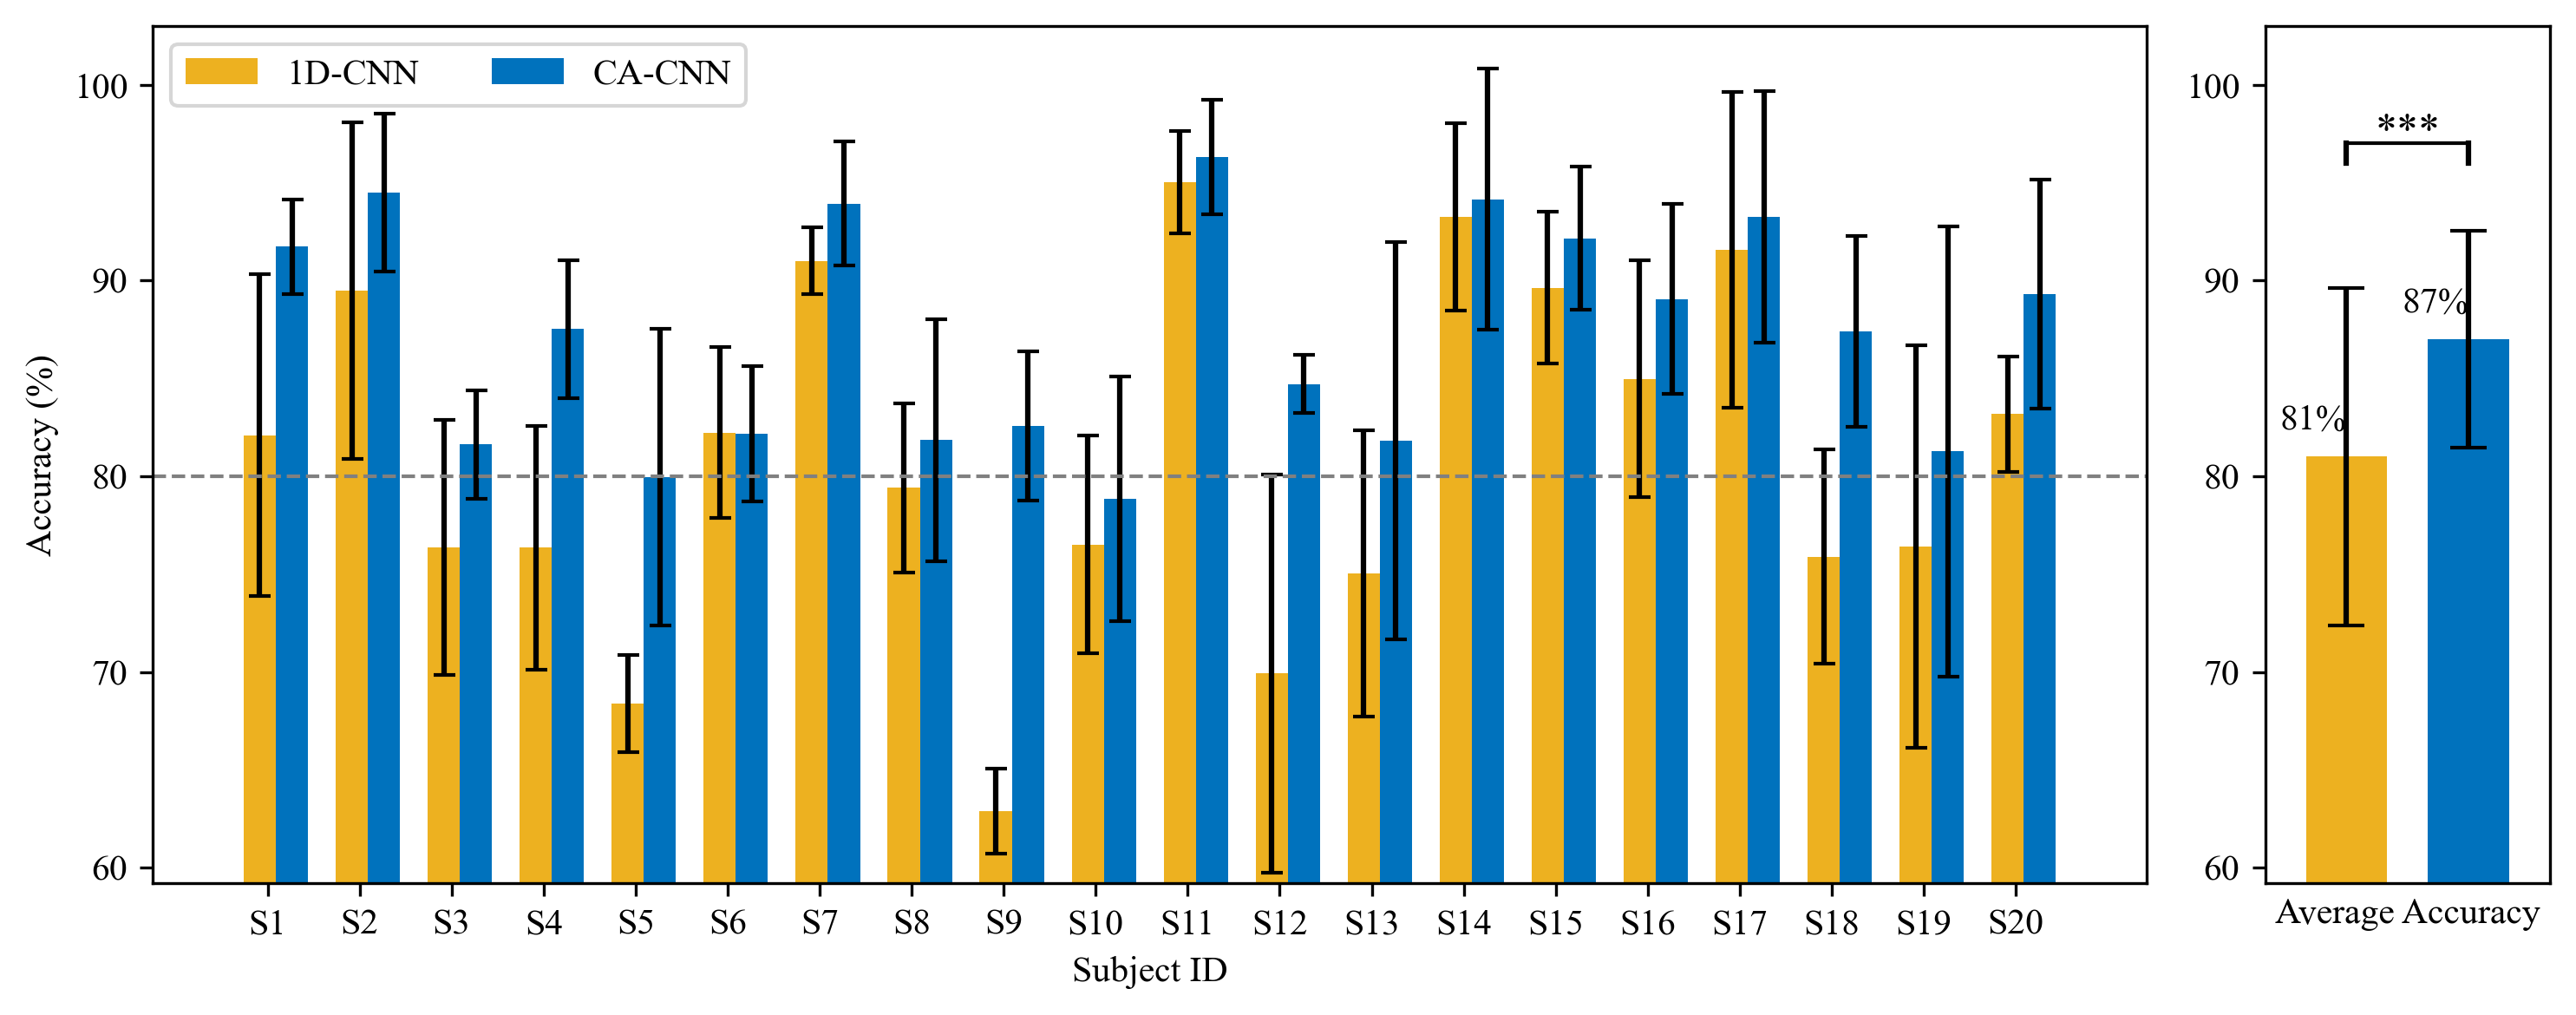

In [28]:
result_files = ['/Users/zj-mac/EEG_3/ASA_dataset/results/averages_1DCNN_SR128_OR50.txt',
         '/Users/zj-mac/EEG_3/ASA_dataset/results/averages_CACNN_SR128_OR50.txt']
legends = ['1D-CNN', 'CA-CNN']  # Replace with your desired legend labels
plot_accuracies_and_average(result_files, legends)

In [582]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
# Function to extract subject accuracies
def extract_subject_accuracies(accuracies):
    subject_accuracies = []
    for subject in range(1, 21):
        subject_accuracies.append(accuracies[str(subject)])
    return subject_accuracies

def boxplot_comparison(files, labels):
    # Set font globally to Times New Roman
    matplotlib.rcParams['font.family'] = 'Times New Roman'
    
    all_model_accuracies = []
    for file_path in files:
        accuracies, _ = read_accuracy_from_file(file_path)
        subject_accuracies = extract_subject_accuracies(accuracies)
        print(np.std(subject_accuracies))
        all_model_accuracies.append(subject_accuracies)

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(5, 3.5), dpi=200)

    # Dynamically generate color palette
    base_colors = ['#7E2F8E', '#D95319', '#77AC30', '#0072BD']

    # Create the boxplot without patch (fill color)
    boxplot = ax.boxplot(all_model_accuracies, patch_artist=False, labels=labels, widths=0.5, 
                         medianprops=dict(linewidth=1), whiskerprops=dict(linewidth=1), 
                         capprops=dict(linewidth=1), boxprops=dict(linewidth=2))

    # Set the y-axis limits and label
    ax.set_ylim(0.47, 1.11)
    ax.set_ylabel('Accuracy (%)')

    # Set the y-tick labels correctly
    tick_values = np.arange(0.5, 1.001, 0.1)
    ax.set_yticks(tick_values)
    ax.set_yticklabels([f'{int(val*100+0.05)}' for val in tick_values])

    ax.axhline(y=0.8, color='grey', linestyle='--', linewidth=1)
    fig.patch.set_facecolor('white')

    # Customize box, whisker, cap, and median line colors
    for i in range(len(boxplot['boxes'])):
        boxplot['boxes'][i].set_color(base_colors[i % len(base_colors)])  # Set box border color
        boxplot['medians'][i].set_color(base_colors[i % len(base_colors)])  # Optional: Match median line color to box
        boxplot['whiskers'][2*i].set_color(base_colors[i % len(base_colors)])  # Set whisker color
        boxplot['whiskers'][2*i+1].set_color(base_colors[i % len(base_colors)])  # Set whisker color
        boxplot['caps'][2*i].set_color(base_colors[i % len(base_colors)])  # Set cap color
        boxplot['caps'][2*i+1].set_color(base_colors[i % len(base_colors)])  # Set cap color

    # Initialize a variable to adjust the height for each significance line
    line_height_increment = 0.035
    base_line_height = 1.00  # Start just above the highest boxplot, adjust as needed

    # Iterate in reverse order, excluding the last model itself
    for i in reversed(range(len(all_model_accuracies)-1)):
        current_model_accuracies = all_model_accuracies[i]
        last_model_accuracies = all_model_accuracies[-1]

        # Perform t-test
        _, p_value = ttest_ind(current_model_accuracies, last_model_accuracies, nan_policy='omit')

        # Determine the y-position for the current significance line
        # This time we start from the top and go downwards
        line_y = base_line_height + (len(all_model_accuracies) - 2 - i) * line_height_increment

        # Draw significance lines and markers
        if p_value < 0.001:
            signif_mark = "***"
        else:
            signif_mark = "n.s."

        # Draw significance line
        ax.plot([i+1, len(all_model_accuracies)], [line_y, line_y], color="black", lw=1.2)

        # Draw vertical caps at the ends of the significance line
        ax.plot([i+1, i+1], [line_y - 0.01, line_y], color="black", lw=1.2)
        ax.plot([len(all_model_accuracies), len(all_model_accuracies)], [line_y - 0.01, line_y], color="black", lw=1.2)

        # Add significance marker
        ax.text((i+1 + len(all_model_accuracies))/2, line_y - 0.01, signif_mark, ha='center', va='bottom', fontsize=12)





0.0730261478855348
0.07171581049531546
0.09130597173788799
0.05558735715070469


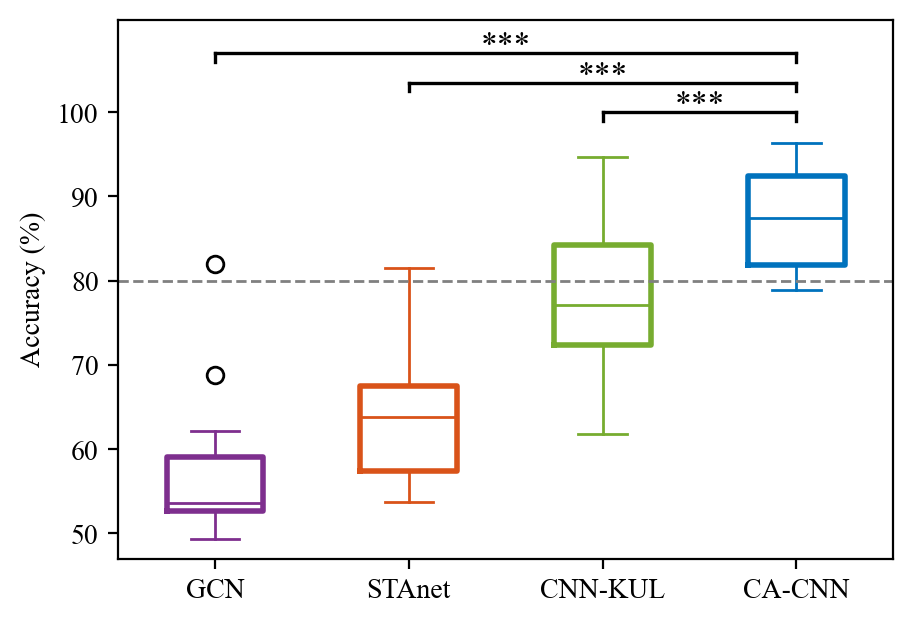

In [583]:
files = ['/Users/zj-mac/EEG_3/cnn_database/result_5/averages_GCN_SR128_OR50.txt',
        '/Users/zj-mac/EEG_3/cnn_database/result_5/averages_STAnet_SR128_OR50.txt',
         '/Users/zj-mac/EEG_3/cnn_database/result_5/averages_KUL_CNN_SR128_OR50.txt',
        '/Users/zj-mac/EEG_3/cnn_database/result_4/averages_attention_5_SR128_OR50.txt']
legends = ['GCN', 'STAnet', 'CNN-KUL', 'CA-CNN']  # Replace with your desired legend labels
boxplot_comparison(files, legends)